In [660]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import copy

Populating the interactive namespace from numpy and matplotlib


/Users/lackey/Library/Python/2.7/lib/python/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'ndim', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [795]:
import sys

#sys.path.insert(1, '/Users/lackey/src/GPflow/GPflow')
#sys.path.append('/Users/lackey/src/GPflow')

sys.path.insert(0, '../src')
import gaussianprocessregression as gpr
import designofexperiment as doe

In [812]:
import imp

imp.reload(gpr)
imp.reload(doe)

<module 'designofexperiment' from '../src/designofexperiment.pyc'>

# Plotting functions and diagnostics

In [849]:
def plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, 
                 interpolation='bicubic', colorbar=True, colorbar_label='z'):
    """Generate a heatmap from the function func.
    """
    # Generate 2d array of z-values
    xs = np.linspace(xlow, xhigh, nx)
    ys = np.linspace(ylow, yhigh, ny)
    zgrid = np.array([[func(x, y) for y in ys] for x in xs])
    
    # Make the plot
    extent = [xs[0], xs[-1], ys[0], ys[-1]]
    im = axes.imshow(zgrid.T, interpolation=interpolation, origin='lower', 
                 extent=extent, aspect='auto')
    
    # Make the colorbar
    if colorbar:
        cb = plt.colorbar(mappable=im, ax=axes)
        cb.set_label(label=colorbar_label)
        
        
def plot_numbered_points(axes, points):
    """
    """
    for i in range(len(points)-1):
        axes.scatter(points[i, 0], points[i, 1], marker='$'+str(i)+'$', s=100, color='r')
        
    axes.scatter(points[-1, 0], points[-1, 1], marker='$'+str(len(points)-1)+'$', s=150, color='orange')
    

def maximum_error(func, gp, limits, error_type='absolute', nsample=100000):
    """
    """
    vps = doe.uniform_random_samples(nsample, limits)

    vps_true = np.array([func(p) for p in vps])
    vps_gp, ysigma = gp.predict(vps, return_std=True)
    
    func_range = np.max(vps_true) - np.min(vps_true)
    #print func_range
    
    if error_type == 'absolute':
        return np.max(np.abs(vps_gp - vps_true))
    elif error_type == 'fractional':
        # Relative error. Not meaningful if the function passes through zero.
        return np.max(np.abs(vps_gp/vps_true - 1.0))
    elif error_type == 'fractional_full_range':
        # Calculate the error relative to the full range of values
        return np.max(np.abs(vps_gp - vps_true)) / func_range
    else:
        raise Exception, "Options for error_type are: 'absolute', 'fractional', 'fractional_full_range'."

# Test the adaptive sampling
## Make and plot the function with the initial LHD samples

In [865]:
def func(x, y):
    return (np.sin(x*(1.0+0.05*x)) + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y

# def func(x, y):
#     return (2.0*np.sin(0.5*x*(1.0+0.05*x)) - 0.3*(x-5.0)**2 + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y

# def func(x, y):
#     if y>0:
#         return (2.0*np.sin(0.5*x*(1.0+0.05*x)) - 0.3*(x-5.0)**2 + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y
#     else:
#         return 10.0

# def func(x, y):
#     return (2.0*np.sin(0.5*x*(1.0+0.05*x)) - 0.3*(x-5.0)**2 + 0.5*x + 10)*0.01*(np.abs(y)-5.0)**2 - 0.1*x*np.abs(y)

In [866]:
# ******* Generate the initial points *******
npoints = 20
limits = np.array([[-9.4, 5.], [-2., 2.]])
points = doe.latin_hypercube(npoints, limits)

# ******* Generate data at the initial points *******
npoints = len(points)
data = np.array([func(points[i, 0], points[i, 1]) for i in range(npoints)])

# # ******* Add random noise *******
# sigma = 1.0e-5
# data += np.random.normal(0.0, sigma, len(data))

data.min(), data.max()

(0.66959329113813193, 5.5225909090297858)

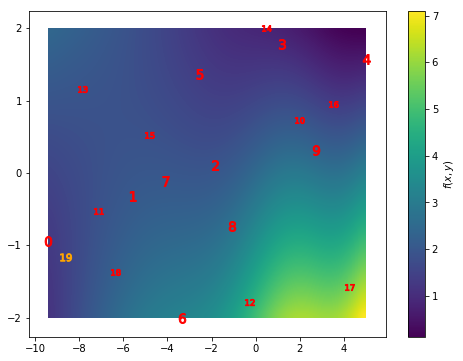

In [867]:
fig, axes = plt.subplots(1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50
plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'$f(x, y)$')
plot_numbered_points(axes, points)

## Generate initial GPR with the LHD samples
### Don't let the bounds on the lengthscale hyperparameters be too much larger than the size of the parameter space
### or the bounds on sigma_f be too much larger than the range if z=f(x, y)

In [868]:
hp0 = np.array([5.0, 10.0, 10.0, 1.0e-8])
hyper_limits = np.array([[1.0, 10.0], [1.0, 25.0], [1.0, 8.0], [1.0e-9, 1.0e-7]])

#kernel_type = 'matern32'
kernel_type = 'matern52'
#kernel_type = 'squaredexponential'

gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                 hyper_limits=hyper_limits, n_restarts_optimizer=9)
print gp.kernel_

4.36**2 * Matern(length_scale=[11.9, 8], nu=2.5) + WhiteKernel(noise_level=1.28e-15)


0.784505178449
1.33210891395
0.117141387362


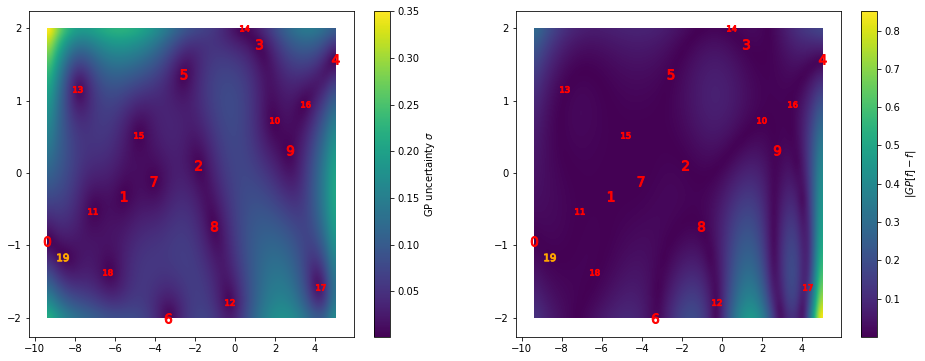

In [869]:
def func_tuple(p):
    return func(p[0], p[1])
print maximum_error(func_tuple, gp, limits, error_type='absolute', nsample=100000)
print maximum_error(func_tuple, gp, limits, error_type='fractional', nsample=100000)
print maximum_error(func_tuple, gp, limits, error_type='fractional_full_range', nsample=100000)

def gp_predict_error(x, y):
    return gp.predict(np.array([[x, y]]), return_std=True)[1][0]

def true_abs_error(x, y):
    return np.abs(gp.predict(np.array([[x, y]]))[0] - func(x, y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50

plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'GP uncertainty $\sigma$')
plot_numbered_points(ax1, points)

plot_2d_func(ax2, true_abs_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'$|GP[f]-f|$')
plot_numbered_points(ax2, points)

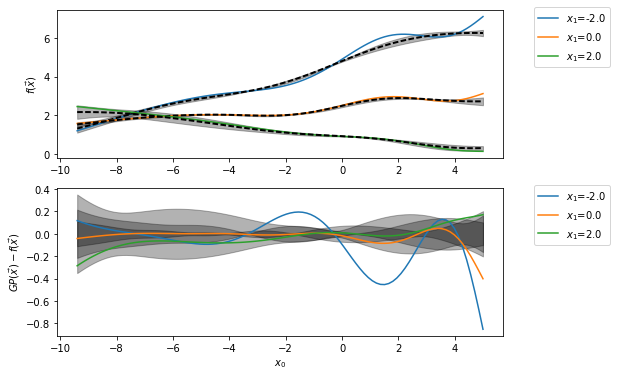

In [870]:
fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(limits[1, 0], limits[1, 1], 3):
    xs = np.linspace(limits[0, 0], limits[0, 1], 100)
    ps = np.array([[x, y] for x in xs])
    
    true = np.array([func(p[0], p[1]) for p in ps])
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(xs, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(xs, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    ax[1].plot(xs, (y_pred-true), label=r'$x_1$='+str(y))
    ax[1].fill_between(xs, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

## Sample new points (*without* updating hyperparameters with new data)

In [871]:
n_new = 20
hp0 = get_hyperparameters(gp)
new_points = gpr.sample_n_new_points_with_fixed_hyperparameters(n_new, points, limits, hp0, kernel_type, 
                                                                nsamples=100000)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


In [872]:
# Get the new data
new_data = np.array([func(new_points[i, 0], new_points[i, 1]) for i in range(len(new_points))])

# All the points and all the data
all_points = np.concatenate((points, np.atleast_2d(new_points)))
all_data = np.concatenate((data, new_data))

# Calculate new gp with all the points and data
gp = gpr.generate_gp(all_points, all_data, hp0, kernel_type=kernel_type, 
                 hyper_limits=hyper_limits, n_restarts_optimizer=9)
print gp.kernel_

4.05**2 * Matern(length_scale=[8.03, 8], nu=2.5) + WhiteKernel(noise_level=4.37e-17)


0.105362142117
0.289484661154
0.0153575203843


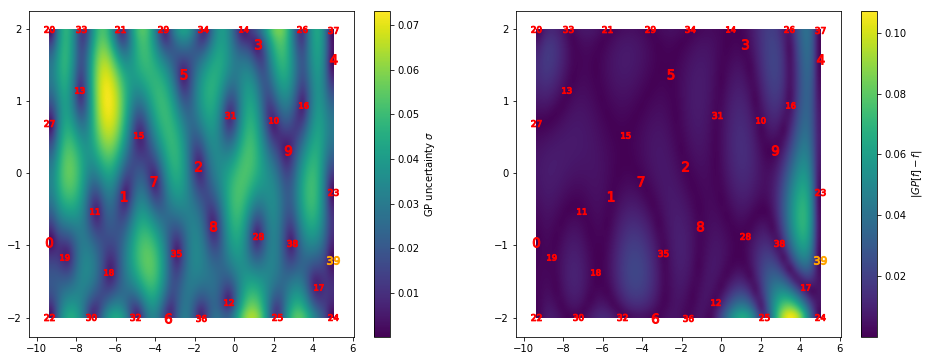

In [873]:
def func_tuple(p):
    return func(p[0], p[1])
print maximum_error(func_tuple, gp, limits, error_type='absolute', nsample=100000)
print maximum_error(func_tuple, gp, limits, error_type='fractional', nsample=100000)
print maximum_error(func_tuple, gp, limits, error_type='fractional_full_range', nsample=100000)

def gp_predict_error(x, y):
    return gp.predict(np.array([[x, y]]), return_std=True)[1][0]

def true_abs_error(x, y):
    return np.abs(gp.predict(np.array([[x, y]]))[0] - func(x, y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50

plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'GP uncertainty $\sigma$')
plot_numbered_points(ax1, all_points)

plot_2d_func(ax2, true_abs_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'$|GP[f]-f|$')
plot_numbered_points(ax2, all_points)

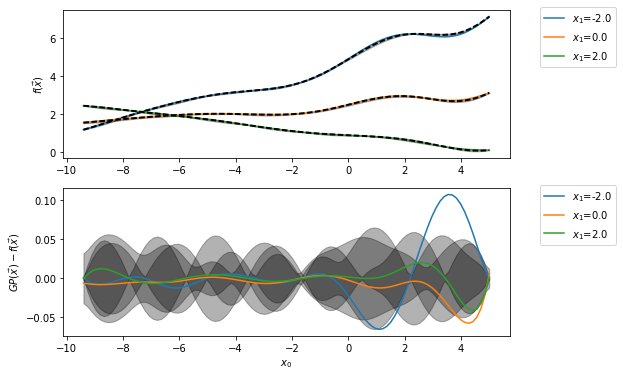

In [874]:
fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(limits[1, 0], limits[1, 1], 3):
    xs = np.linspace(limits[0, 0], limits[0, 1], 100)
    ps = np.array([[x, y] for x in xs])
    
    true = np.array([func(p[0], p[1]) for p in ps])
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(xs, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(xs, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    ax[1].plot(xs, (y_pred-true), label=r'$x_1$='+str(y))
    ax[1].fill_between(xs, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

## Sample new points (updating hyperparameters with new data)

In [875]:
for i in range(20):
    # You could dynamically set the bounds hyper_limits so that sigma_f is no more than 
    # ~2x the largest deviation of the function from 0: np.max(np.abs(data))
    
    # Have 2 separate functions
    # One that finds a new point without looking the data as an argument and fixed hyperparameters
    # One that includes the data when looking for new points
    
    print i,
    hp0 = get_hyperparameters(gp)
    
    print gp.kernel_
    point_new, gp = gpr.sample_new_point_with_new_data(points, data, limits, hp0, kernel_type, hyper_limits, 
                                                   n_restarts_optimizer=9, nsamples=100000)
    
    # Evaluate the new data at the new point
    data_new = func(point_new[0], point_new[1])
    
    # Add the new point and data to the old points and data 
    points = np.concatenate((points, np.atleast_2d(point_new)))
    data = np.concatenate((data, np.array([data_new])))

0 4.05**2 * Matern(length_scale=[8.03, 8], nu=2.5) + WhiteKernel(noise_level=4.37e-17)
1 4.36**2 * Matern(length_scale=[11.9, 8], nu=2.5) + WhiteKernel(noise_level=4.35e-15)
2 4.38**2 * Matern(length_scale=[12, 8], nu=2.5) + WhiteKernel(noise_level=1.12e-18)
3 4.26**2 * Matern(length_scale=[11.9, 8], nu=2.5) + WhiteKernel(noise_level=1.46e-15)
4 4.18**2 * Matern(length_scale=[11.9, 8], nu=2.5) + WhiteKernel(noise_level=1.09e-18)
5 4.03**2 * Matern(length_scale=[10.8, 8], nu=2.5) + WhiteKernel(noise_level=1.92e-17)
6 5.84**2 * Matern(length_scale=[11.3, 8], nu=2.5) + WhiteKernel(noise_level=1.92e-17)
7 3.4**2 * Matern(length_scale=[13.4, 2.63], nu=2.5) + WhiteKernel(noise_level=8.13e-15)
8 4.97**2 * Matern(length_scale=[8.17, 8], nu=2.5) + WhiteKernel(noise_level=2.68e-16)
9 4.77**2 * Matern(length_scale=[8, 8], nu=2.5) + WhiteKernel(noise_level=1.07e-16)
10 4.75**2 * Matern(length_scale=[8.09, 8], nu=2.5) + WhiteKernel(noise_level=1.07e-16)
11 4.72**2 * Matern(length_scale=[8.17, 8], n

In [878]:
# Calculate new gp with new samples
point_new, gp = sample_new_point(points, data, hp0, limits, kernel_type=kernel_type, hyper_limits=hyper_limits)
print gp.kernel_

4.01**2 * Matern(length_scale=[7.76, 8], nu=2.5) + WhiteKernel(noise_level=1.19e-15)


0.0558785349711
0.201530449246
0.00807912341236


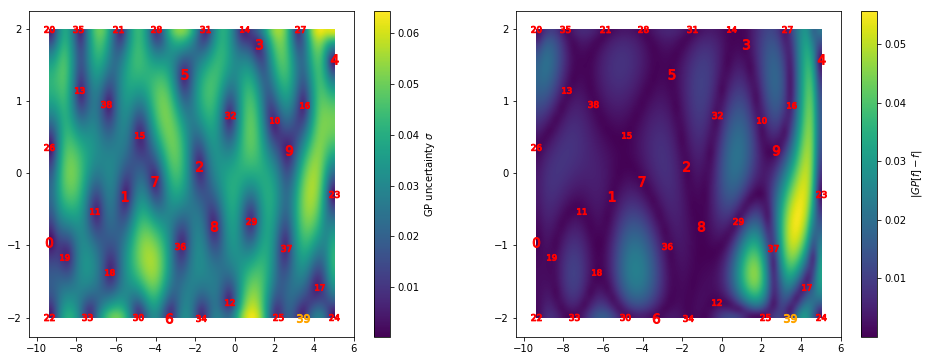

In [879]:
def func_tuple(p):
    return func(p[0], p[1])
print maximum_error(func_tuple, gp, limits, error_type='absolute', nsample=100000)
print maximum_error(func_tuple, gp, limits, error_type='fractional', nsample=100000)
print maximum_error(func_tuple, gp, limits, error_type='fractional_full_range', nsample=100000)

def gp_predict_error(x, y):
    return gp.predict(np.array([[x, y]]), return_std=True)[1][0]

def true_abs_error(x, y):
    return np.abs(gp.predict(np.array([[x, y]]))[0] - func(x, y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50

plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'GP uncertainty $\sigma$')
plot_numbered_points(ax1, points)

plot_2d_func(ax2, true_abs_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'$|GP[f]-f|$')
plot_numbered_points(ax2, points)

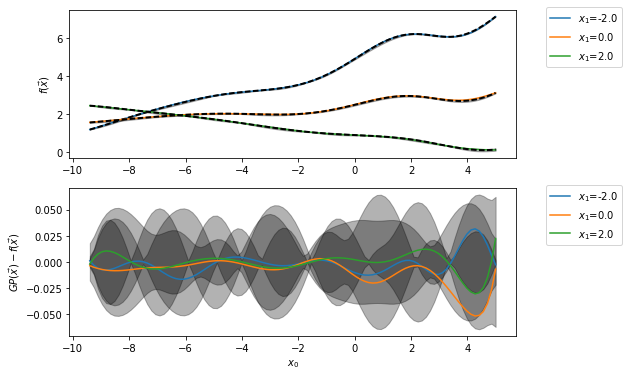

In [880]:
fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(limits[1, 0], limits[1, 1], 3):
    xs = np.linspace(limits[0, 0], limits[0, 1], 100)
    ps = np.array([[x, y] for x in xs])
    
    true = np.array([func(p[0], p[1]) for p in ps])
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(xs, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(xs, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    ax[1].plot(xs, (y_pred-true), label=r'$x_1$='+str(y))
    ax[1].fill_between(xs, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# Test with 5d function

In [896]:
def func(x):
    return (np.sin(0.5*x[0]*(1.0+0.05*x[0])) + 0.5*x[0] + 10)*0.01*(x[1]-5.0)**2\
    - 0.1*x[0]*x[1] + 0.02*x[2]**2 + 0.02*x[3]**2 - 0.02*(x[4]-5)*x[3]

In [897]:
# ******* Generate the initial points *******
npoints = 200
limits = limits = np.array([[0, 10], [0, 20], [0, 30], [0, 40], [0, 50]])
points = latin_hypercube(npoints, limits)

# ******* Generate data at the initial points *******
npoints = len(points)
data = np.array([func(points[i]) for i in range(npoints)])

# # ******* Add random noise *******
# sigma = 1.0e-5
# data += np.random.normal(0.0, sigma, len(data))

data.min(), data.max()

(-11.717415057340837, 50.224136719353474)

In [898]:
hp0 = np.array([25.0, 10.0, 20.0, 30.0, 40.0, 50.0, 1.0e-8])
hyper_limits = np.array([[1.0, 100.0], [1.0, 20.0], [1.0, 40.0], [1.0, 60.0], [1.0, 80.0], [1.0, 100.0], [1.0e-9, 1.0e-7]])

#kernel_type = 'matern32'
kernel_type = 'matern52'
#kernel_type = 'squaredexponential'

gp = generate_gp(points, data, hp0, kernel_type=kernel_type, 
                 hyper_limits=hyper_limits, n_restarts_optimizer=9)
print gp.kernel_

21.1**2 * Matern(length_scale=[18.2, 33.3, 60, 80, 100], nu=2.5) + WhiteKernel(noise_level=4.78e-15)


7.04088350813
5262.22847095
0.0666601981238


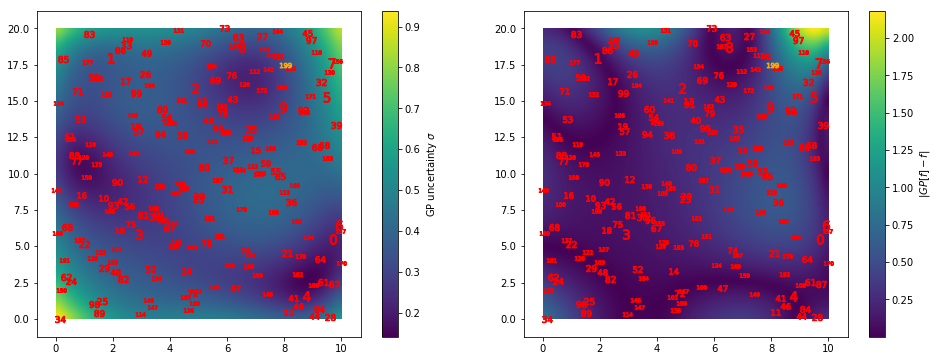

In [899]:
print maximum_error(func, gp, limits, error_type='absolute', nsample=100000)
print maximum_error(func, gp, limits, error_type='fractional', nsample=100000)
print maximum_error(func, gp, limits, error_type='fractional_full_range', nsample=100000)

x2, x3, x4 = 10, 10, 10
def gp_predict_error(x0, x1):
    return gp.predict(np.array([[x0, x1, x2, x3, x4]]), return_std=True)[1][0]

def true_abs_error(x0, x1):
    return np.abs(gp.predict(np.array([[x0, x1, x2, x3, x4]]))[0] - func(np.array([x0, x1, x2, x3, x4])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50

plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'GP uncertainty $\sigma$')
plot_numbered_points(ax1, points)

plot_2d_func(ax2, true_abs_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'$|GP[f]-f|$')
plot_numbered_points(ax2, points)

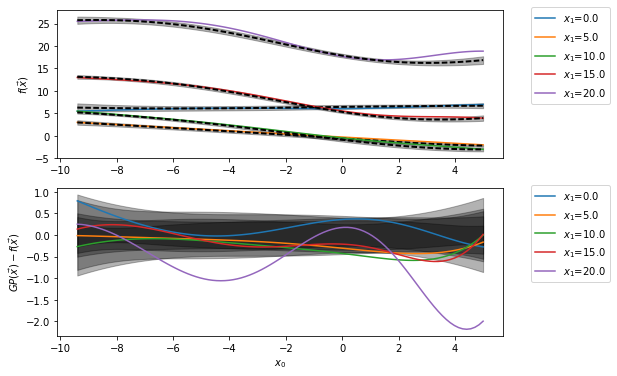

In [ ]:
x0, x1, x2 = 10, 10, 10

fig, ax = plt.subplots(2, figsize=(8, 6))
for x1 in np.linspace(0, 20, 5):
    x0s = np.linspace(0, 10, 100)
    ps = np.array([[x0, x1, x2, x3, x4] for x0 in x0s])
    
    true = np.array([func(p) for p in ps])
    ax[0].plot(xs, true, label=r'$x_1$='+str(x1))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(xs, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(xs, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    ax[1].plot(xs, (y_pred-true), label=r'$x_1$='+str(x1))
    ax[1].fill_between(xs, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

## Find new points with fixed hyperparameters

In [ ]:
n_new = 200
hp0 = get_hyperparameters(gp)
new_points = gpr.sample_n_new_points_with_fixed_hyperparameters(n_new, points, limits, hp0, kernel_type, nsamples=100000)

0 1 2 3 4 5 6 7 8 9 10

In [ ]:
# ******* plot data *******
fig = plt.figure(figsize=(14, 6))

axes = fig.add_subplot(121)
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50
plot_numbered_points(axes, new_points)

axes = fig.add_subplot(122, projection='3d')
x, y, z = new_points[:, 0], new_points[:, 1], new_points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

In [ ]:
# Get the new data
new_data = np.array([func(new_points[i]) for i in range(len(new_points))])

# All the points and all the data
all_points = np.concatenate((points, np.atleast_2d(new_points)))
all_data = np.concatenate((data, new_data))

# Calculate new gp with all the points and data
gp = generate_gp(all_points, all_data, hp0, kernel_type=kernel_type, 
                 hyper_limits=hyper_limits, n_restarts_optimizer=9)
print gp.kernel_

In [ ]:
print maximum_error(func, gp, limits, error_type='absolute', nsample=100000)
print maximum_error(func, gp, limits, error_type='fractional', nsample=100000)
print maximum_error(func, gp, limits, error_type='fractional_full_range', nsample=100000)

x2, x3, x4 = 10, 10, 10
def gp_predict_error(x0, x1):
    return gp.predict(np.array([[x0, x1, x2, x3, x4]]), return_std=True)[1][0]

def true_abs_error(x0, x1):
    return np.abs(gp.predict(np.array([[x0, x1, x2, x3, x4]]))[0] - func(np.array([x0, x1, x2, x3, x4])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50

plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'GP uncertainty $\sigma$')
plot_numbered_points(ax1, all_points)

plot_2d_func(ax2, true_abs_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'$|GP[f]-f|$')
plot_numbered_points(ax2, all_points)

In [ ]:
x0, x1, x2 = 10, 10, 10

fig, ax = plt.subplots(2, figsize=(8, 6))
for x1 in np.linspace(0, 20, 5):
    x0s = np.linspace(0, 10, 100)
    ps = np.array([[x0, x1, x2, x3, x4] for x0 in x0s])
    
    true = np.array([func(p) for p in ps])
    ax[0].plot(xs, true, label=r'$x_1$='+str(x1))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(xs, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(xs, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    ax[1].plot(xs, (y_pred-true), label=r'$x_1$='+str(x1))
    ax[1].fill_between(xs, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))